In [3]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from utils_cells import get_images_list, transform_image, transform_target, resize_with_padding
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import torchvision.transforms.functional as F
import torch
from torchvision import transforms
from torchvision.transforms import functional as F
import cv2
from sklearn.model_selection import train_test_split
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torchmetrics import Precision, Recall
import numpy as np
import datetime
import random
import time
import torchvision.models as models

import random

class ImageDataset(Dataset):
    def __init__(self, data_path, transform=None, target_transform=None, reduce=False):
        self.transform = transform
        self.target_transform = target_transform
        self.dataset = shuffle(self.load_dataset(data_path))

    def load_dataset(self, path):
        path = []
        classes = []
        for image_class in os.listdir('cells_final'):
            for img in os.listdir(f'cells_final/{image_class}'):
                path.append(f'cells_final/{image_class}/{img}')
                classes.append(image_class)

        dataset_final = pd.DataFrame()
        dataset_final['path'] = path
        dataset_final['class'] = classes
        return dataset_final                
                          
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = cv2.imread(f'{self.dataset["path"].loc[idx]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_CUBIC)
        
        image = resize_with_padding(image, (32, 32))
        image = image.astype(np.float32)
        image = image/255.0
        image = self.transform(image = image)['image'] if self.transform is not None else image

        target = self.dataset['class'].loc[idx]

        if target.strip() == 'normal':
            target_ = [1, 0, 0, 0]
        elif target.strip() == 'inflammatory':
            target_ = [0, 1, 0, 0]
        elif target.strip() == 'tumor':
            target_ = [0, 0, 1, 0]
        elif target.strip() == 'other':
            target_ = [0, 0, 0, 1]
        else:
            print(target)
        
        image = F.to_tensor(image)
        

        return image.float(), torch.Tensor(np.array(target_, dtype=np.float32))

In [4]:
import torch
import torch.nn as nn
from einops import rearrange

import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import torch.optim as optim

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # [3, 32, 32] -> [16, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [16, 16, 16] -> [32, 8, 8]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # [32, 8, 8] -> [64, 4, 4]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128) ,
            nn.ReLU(),
        )



        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(128, 128 * 4 * 4) , # Expand back to match the flattened input size
            nn.Unflatten(dim=1, unflattened_size=(64, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64, 4, 4] -> [32, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [32, 8, 8] -> [16, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),   # [16, 16, 16] -> [3, 32, 32]
            nn.Sigmoid(),  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Example usage


model = ConvAutoencoder()

# Sample input
x = torch.randn(1, 3, 32, 32)
reconstructed_img = model(x)

print(reconstructed_img.shape)  # Should output torch.Size([1, 3, 32, 32])


torch.Size([1, 3, 32, 32])


In [5]:
model = model.to('cuda')

In [6]:
import time
import torch
import wandb
from torch.utils.data import DataLoader
import numpy as np

# Initialize WandB
run_name = f'conv_autoencoder_training_{datetime.datetime.now()}'

# Configuration
batch_size = 1024
learning_rate = 1e-3
num_epochs = 200
early_stop_patience = 15  # Number of epochs to wait for improvement
run_path = f'training_checkpoints/{run_name}'

# DataLoader
trainset = ImageDataset(data_path='train_data')
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=5)

# Model, loss function, optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early Stopping
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    print('========================================')
    print(f'EPOCH: {epoch}')
    time_start = time.perf_counter()
    model.train()
    
    epoch_loss = 0
    for batch_idx, (inputs, _) in enumerate(trainloader):
        inputs = inputs.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # Reconstruction loss
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(trainloader)
    print(f'Epoch {epoch} Average Loss: {avg_loss}')
    
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), f'{run_path}.pth')
        print(f'Saved new best model with loss {best_loss}')
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
    
    if patience_counter >= early_stop_patience:
        print(f'Early stopping at epoch {epoch} with best loss {best_loss}')
        break
    
    time_epoch = time.perf_counter() - time_start
    print(f'Epoch {epoch} time: {time_epoch/60} minutes')
    print('--------------------------------')

# Load the best model state dict
print(f'Loading model from {run_path}.pth')
model.load_state_dict(torch.load(f'{run_path}.pth'))

EPOCH: 0
Epoch 0 Average Loss: 0.10320915783395862
Saved new best model with loss 0.10320915783395862
Epoch 0 time: 0.07450522584999816 minutes
--------------------------------
EPOCH: 1
Epoch 1 Average Loss: 0.05667227479589261
Saved new best model with loss 0.05667227479589261
Epoch 1 time: 0.07343011918333105 minutes
--------------------------------
EPOCH: 2
Epoch 2 Average Loss: 0.04911268026669427
Saved new best model with loss 0.04911268026669427
Epoch 2 time: 0.07278692875000464 minutes
--------------------------------
EPOCH: 3
Epoch 3 Average Loss: 0.04524212983427661
Saved new best model with loss 0.04524212983427661
Epoch 3 time: 0.07216714694999761 minutes
--------------------------------
EPOCH: 4
Epoch 4 Average Loss: 0.04297227433363203
Saved new best model with loss 0.04297227433363203
Epoch 4 time: 0.07112393328333534 minutes
--------------------------------
EPOCH: 5
Epoch 5 Average Loss: 0.041309068932293275
Saved new best model with loss 0.041309068932293275
Epoch 5 tim

<All keys matched successfully>

In [7]:
model.load_state_dict(torch.load(f'training_checkpoints/conv_autoencoder_training_2024-08-22 16:37:59.435421.pth'))
features = []
classes = []
paths = []
model.eval()
trainset = ImageDataset(data_path='train_data')
torch.multiprocessing.set_sharing_strategy('file_system')
model = model.to('cuda')
with torch.no_grad():
    for idx in range(0, len(trainset)-1):
        img, cls = trainset[idx]
        classes.append(np.argmax(cls.cpu().detach().numpy()))
        img = img.unsqueeze(0).to('cuda')
        feature = model.encoder(img)
        features.append(feature.cpu().detach().numpy())


    


In [8]:
cls = np.argmax(np.array(classes), axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
len(features[1][0])

In [9]:
features = [feature[0] for feature in features]

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
arr = np.array(features)
arr = MinMaxScaler().fit_transform(np.array(arr))

In [11]:
df = pd.DataFrame()

In [12]:
import numpy as np



In [13]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca_embs = pca.fit_transform(np.array(arr))

# Add to dataframe for convenience
df['pca_x'] = pca_embs[:, 0]
df['pca_y'] = pca_embs[:, 1]


In [15]:
import umap.umap_ as umap

# Perform UMAP
umap_reducer = umap.UMAP(n_components=2, metric="correlation", n_jobs=-1, min_dist=0.00001, n_neighbors=100)
umap_embs = umap_reducer.fit_transform(arr)

# Add to dataframe for convenience
df['umap_x'] = umap_embs[:, 0]
df['umap_y'] = umap_embs[:, 1]


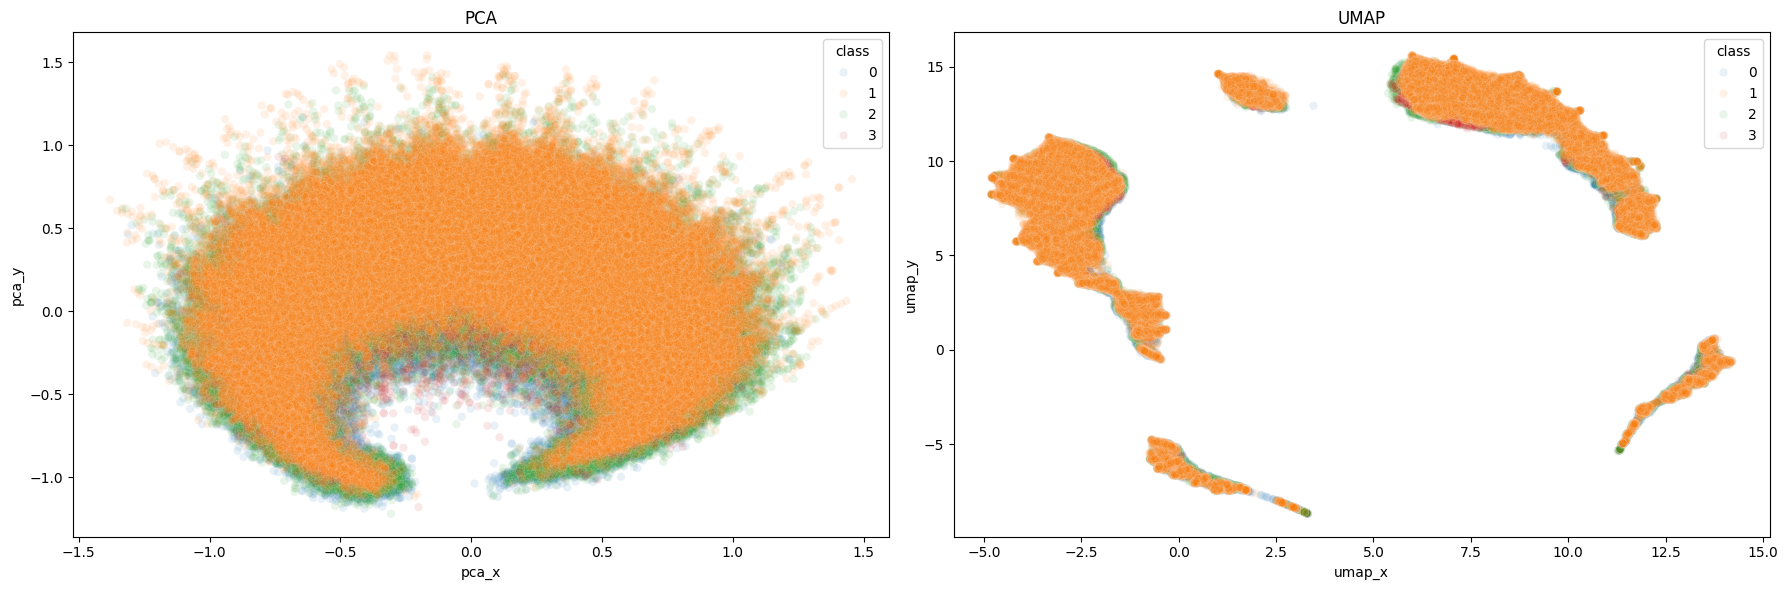

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
df['class'] = classes
# Define figure size and number of subplots
FS = (18, 6)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=FS)

# t-SNE plot


# PCA plot
sns.scatterplot(ax=axes[0], x='pca_x', y='pca_y', hue='class', data=df, palette='tab10', alpha=0.1)
axes[0].set_title('PCA')
axes[0].set_xlabel('pca_x')
axes[0].set_ylabel('pca_y')

# UMAP plot
sns.scatterplot(ax=axes[1], x='umap_x', y='umap_y', hue='class', data=df, palette='tab10', alpha=0.1)
axes[1].set_title('UMAP')
axes[1].set_xlabel('umap_x')
axes[1].set_ylabel('umap_y')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


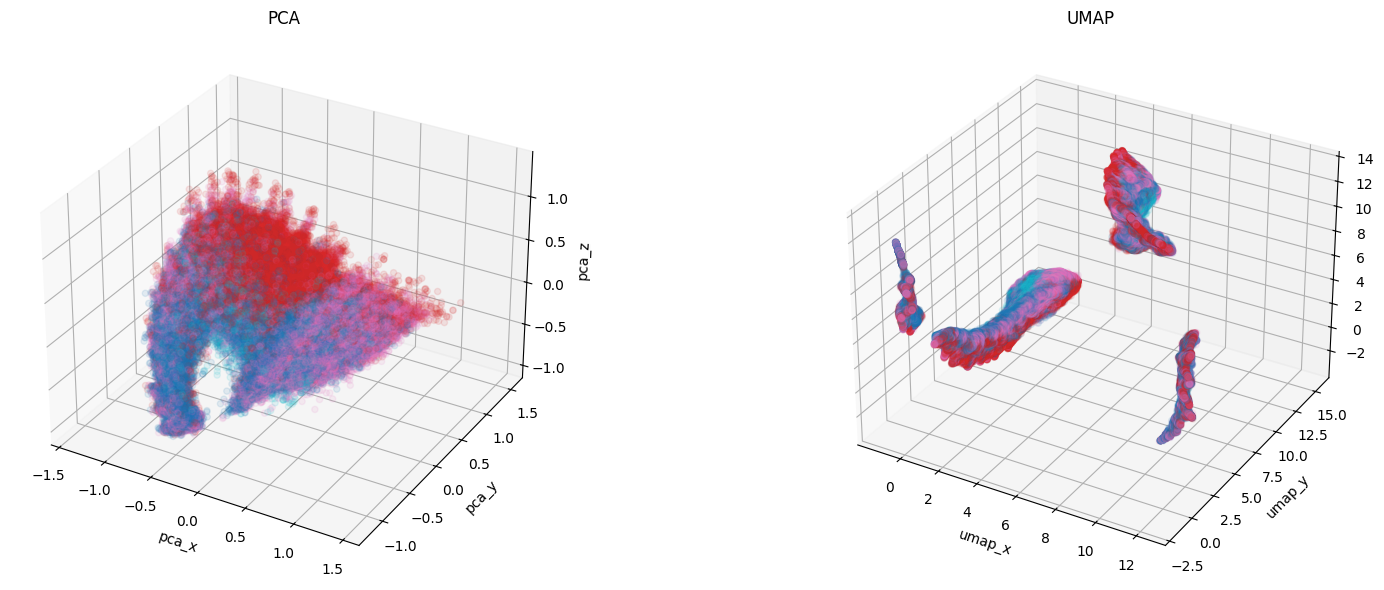

In [18]:
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting toolkit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'arr' and 'classes' are defined somewhere earlier in the code
# and the dataframes 'df' is also available

# Perform PCA
pca = PCA(n_components=3)
pca_embs = pca.fit_transform(np.array(arr))

# Add to dataframe for convenience
df['pca_x'] = pca_embs[:, 0]
df['pca_y'] = pca_embs[:, 1]
df['pca_z'] = pca_embs[:, 2]  # Adding z-axis

# Perform UMAP
umap_reducer = umap.UMAP(n_components=3, metric="euclidean", n_jobs=-1, min_dist=0.2, n_neighbors=100)
umap_embs = umap_reducer.fit_transform(arr)

# Add to dataframe for convenience
df['umap_x'] = umap_embs[:, 0]
df['umap_y'] = umap_embs[:, 1]
df['umap_z'] = umap_embs[:, 2]  # Adding z-axis

df['class'] = classes

# Define figure size and number of subplots
FS = (18, 6)

# Create subplots
fig = plt.figure(figsize=FS)

# PCA 3D plot
ax_pca = fig.add_subplot(121, projection='3d')
sc_pca = ax_pca.scatter(df['pca_x'], df['pca_y'], df['pca_z'], c=df['class'], cmap='tab10', alpha=0.01)
ax_pca.set_title('PCA')
ax_pca.set_xlabel('pca_x')
ax_pca.set_ylabel('pca_y')
ax_pca.set_zlabel('pca_z')

# UMAP 3D plot
ax_umap = fig.add_subplot(122, projection='3d')
sc_umap = ax_umap.scatter(df['umap_x'], df['umap_y'], df['umap_z'], c=df['class'], cmap='tab10', alpha=0.01)
ax_umap.set_title('UMAP')
ax_umap.set_xlabel('umap_x')
ax_umap.set_ylabel('umap_y')
ax_umap.set_zlabel('umap_z')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


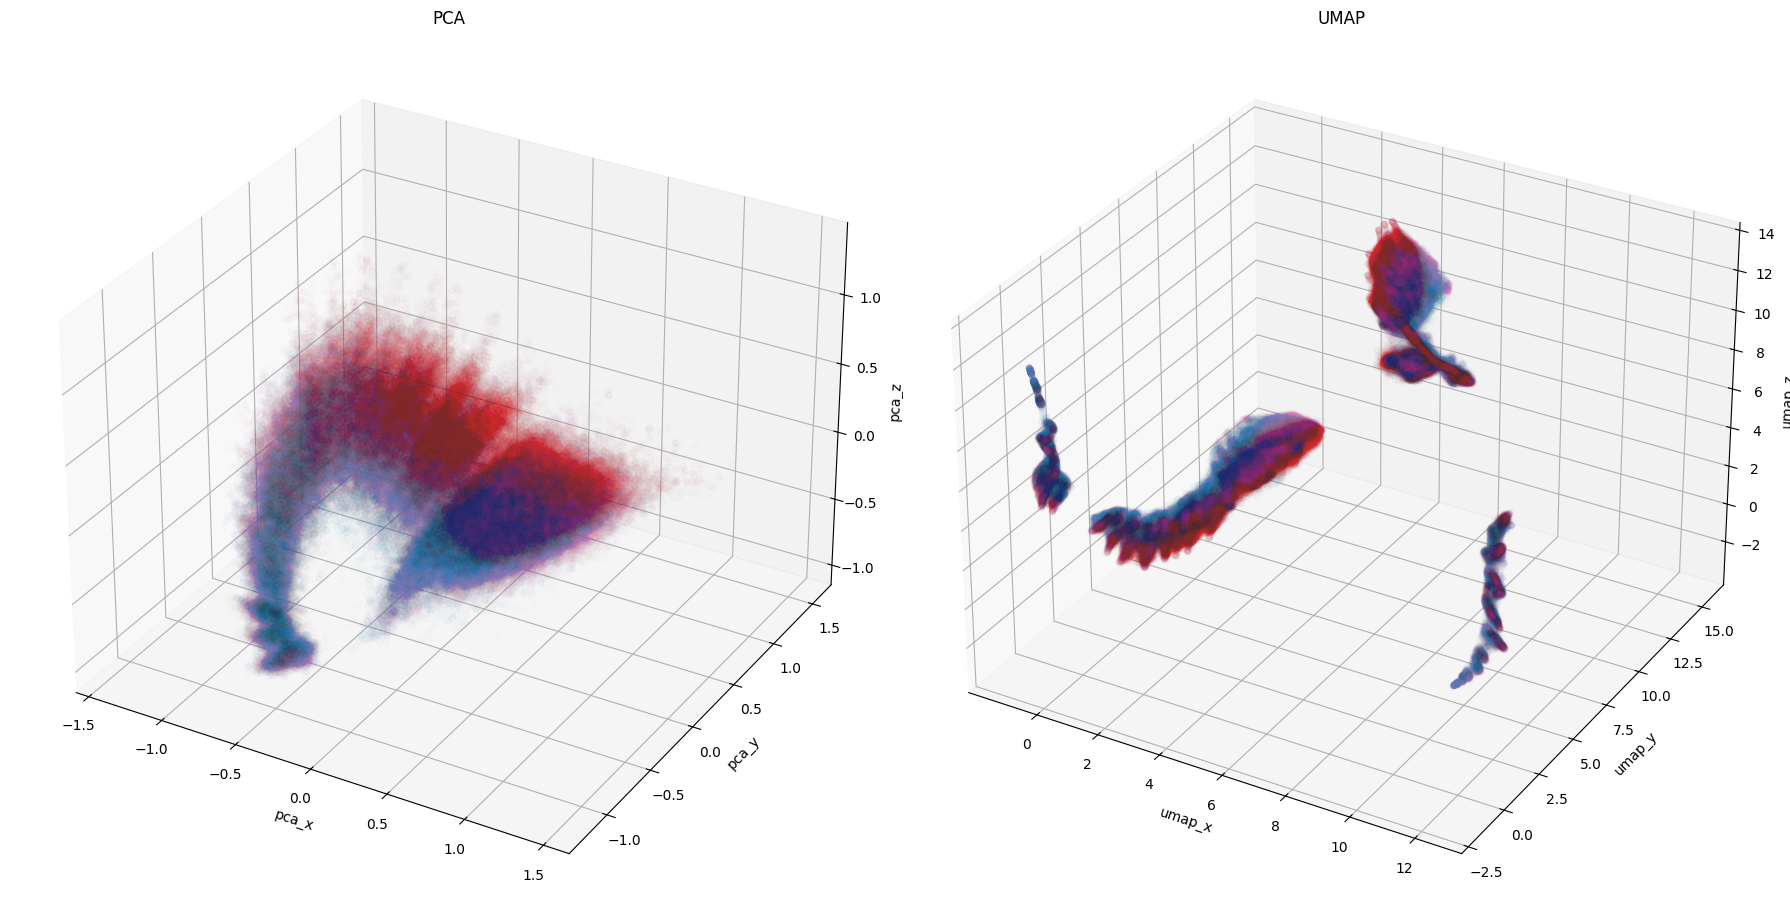

In [20]:
fig = plt.figure(figsize=FS)

# PCA 3D plot
ax_pca = fig.add_subplot(121, projection='3d')
sc_pca = ax_pca.scatter(df['pca_x'], df['pca_y'], df['pca_z'], c=df['class'], cmap='tab10', alpha=0.01)
ax_pca.set_title('PCA')
ax_pca.set_xlabel('pca_x')
ax_pca.set_ylabel('pca_y')
ax_pca.set_zlabel('pca_z')

# UMAP 3D plot
ax_umap = fig.add_subplot(122, projection='3d')
sc_umap = ax_umap.scatter(df['umap_x'], df['umap_y'], df['umap_z'], c=df['class'], cmap='tab10', alpha=0.01)
ax_umap.set_title('UMAP')
ax_umap.set_xlabel('umap_x')
ax_umap.set_ylabel('umap_y')
ax_umap.set_zlabel('umap_z')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


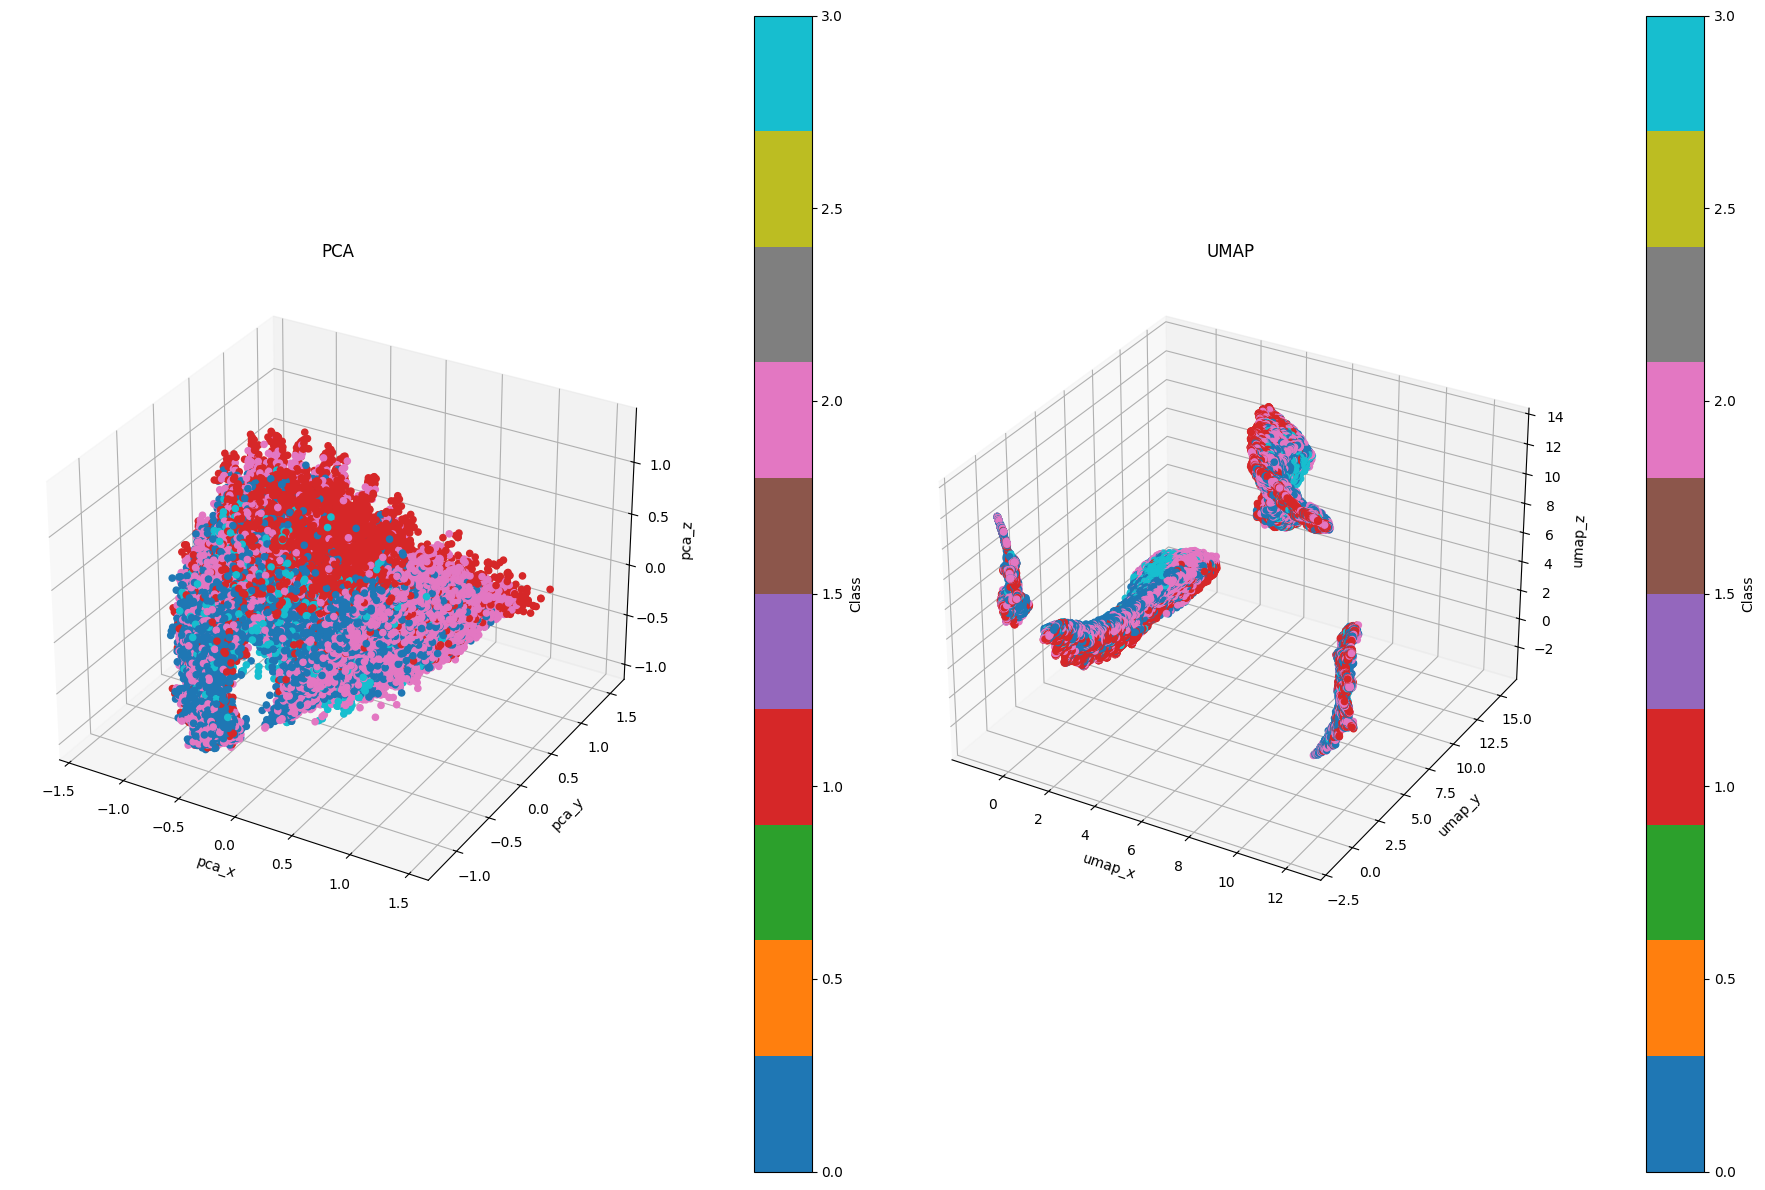

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Define figure size
FS = (18, 12)

# Create the figure
fig = plt.figure(figsize=FS)

# Define a discrete colormap
cmap = plt.get_cmap('tab10', 4)  # 4 discrete colors for 4 classes

# Class labels
class_labels = ['Normal', 'Inflammatory', 'Tumor', 'Other']

# PCA 3D plot
ax_pca = fig.add_subplot(121, projection='3d')
sc_pca = ax_pca.scatter(df['pca_x'], df['pca_y'], df['pca_z'], c=df['class'], cmap=cmap, alpha=0.05)  # Points with alpha 0.05
ax_pca.set_title('PCA')
ax_pca.set_xlabel('pca_x')
ax_pca.set_ylabel('pca_y')
ax_pca.set_zlabel('pca_z')

# Adding a discrete colorbar for PCA
cbar_pca = plt.colorbar(sc_pca, ax=ax_pca, ticks=np.arange(0, 4), pad=0.1)
cbar_pca.set_label('Class')
cbar_pca.set_ticks([0, 1, 2, 3])
cbar_pca.set_ticklabels(class_labels)

# UMAP 3D plot
ax_umap = fig.add_subplot(122, projection='3d')
sc_umap = ax_umap.scatter(df['umap_x'], df['umap_y'], df['umap_z'], c=df['class'], cmap=cmap, alpha=0.05)  # Points with alpha 0.05
ax_umap.set_title('UMAP')
ax_umap.set_xlabel('umap_x')
ax_umap.set_ylabel('umap_y')
ax_umap.set_zlabel('umap_z')

# Adding a discrete colorbar for UMAP
cbar_umap = plt.colorbar(sc_umap, ax=ax_umap, ticks=np.arange(0, 4), pad=0.1)
cbar_umap.set_label('Class')
cbar_umap.set_ticks([0, 1, 2, 3])
cbar_umap.set_ticklabels(class_labels)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


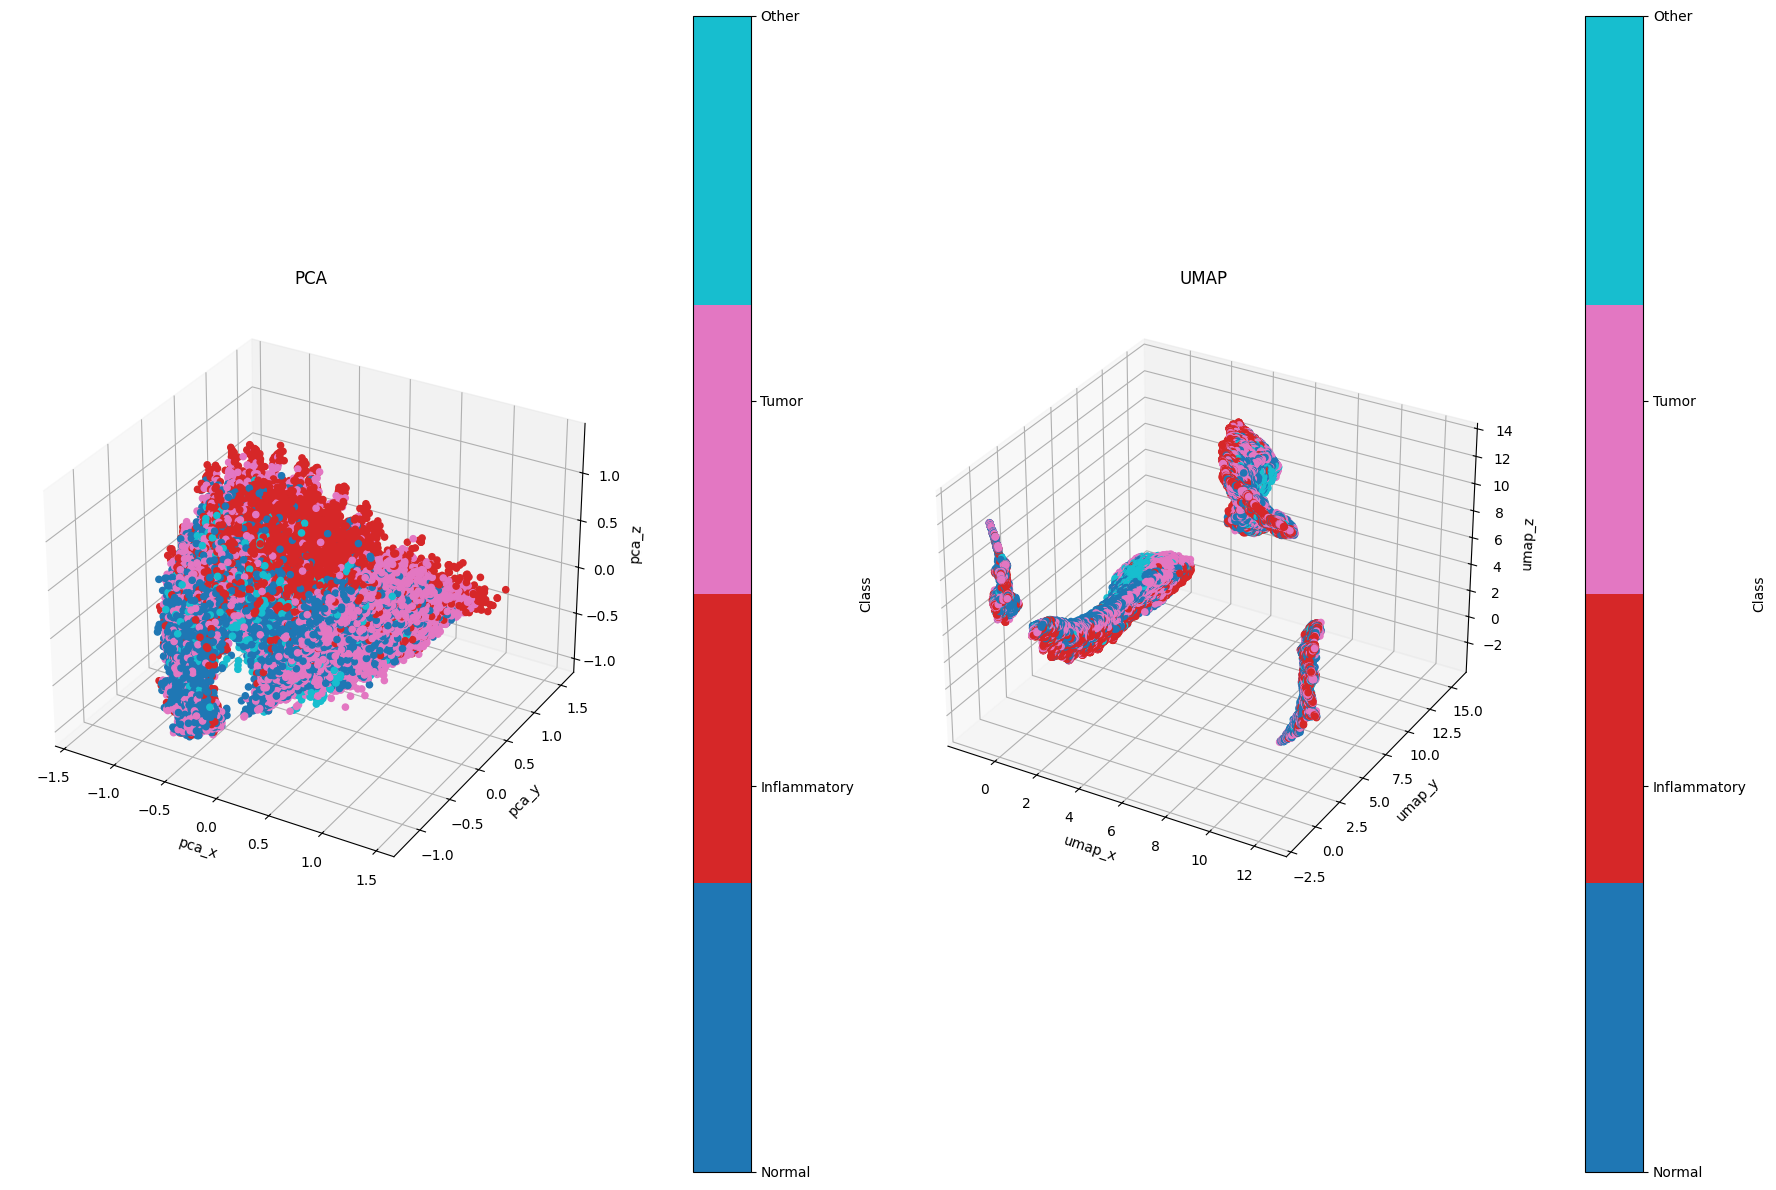

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Define figure size
FIGURE_SIZE = (18, 12)

# Define a discrete colormap with 4 colors
COLORMAP = plt.get_cmap('tab10', 4)

# Class labels
CLASS_LABELS = ['Normal', 'Inflammatory', 'Tumor', 'Other']

def create_subplot(ax, df, x, y, z, title, xlabel, ylabel, zlabel):
    """Create a 3D subplot with a scatter plot and a discrete colorbar"""
    sc = ax.scatter(df[x], df[y], df[z], c=df['class'], cmap=COLORMAP, alpha=1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    
    # Add a discrete colorbar
    cbar = plt.colorbar(sc, ax=ax, ticks=np.arange(0, 4), pad=0.1)
    cbar.set_label('Class')
    cbar.set_ticks([0, 1, 2, 3])
    cbar.set_ticklabels(CLASS_LABELS)
    
    return ax

# Create the figure
fig = plt.figure(figsize=FIGURE_SIZE)

# Create subplots
ax_pca = fig.add_subplot(121, projection='3d')
ax_pca = create_subplot(ax_pca, df, 'pca_x', 'pca_y', 'pca_z', 'PCA', 'pca_x', 'pca_y', 'pca_z')

ax_umap = fig.add_subplot(122, projection='3d')
ax_umap = create_subplot(ax_umap, df, 'umap_x', 'umap_y', 'umap_z', 'UMAP', 'umap_x', 'umap_y', 'umap_z')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


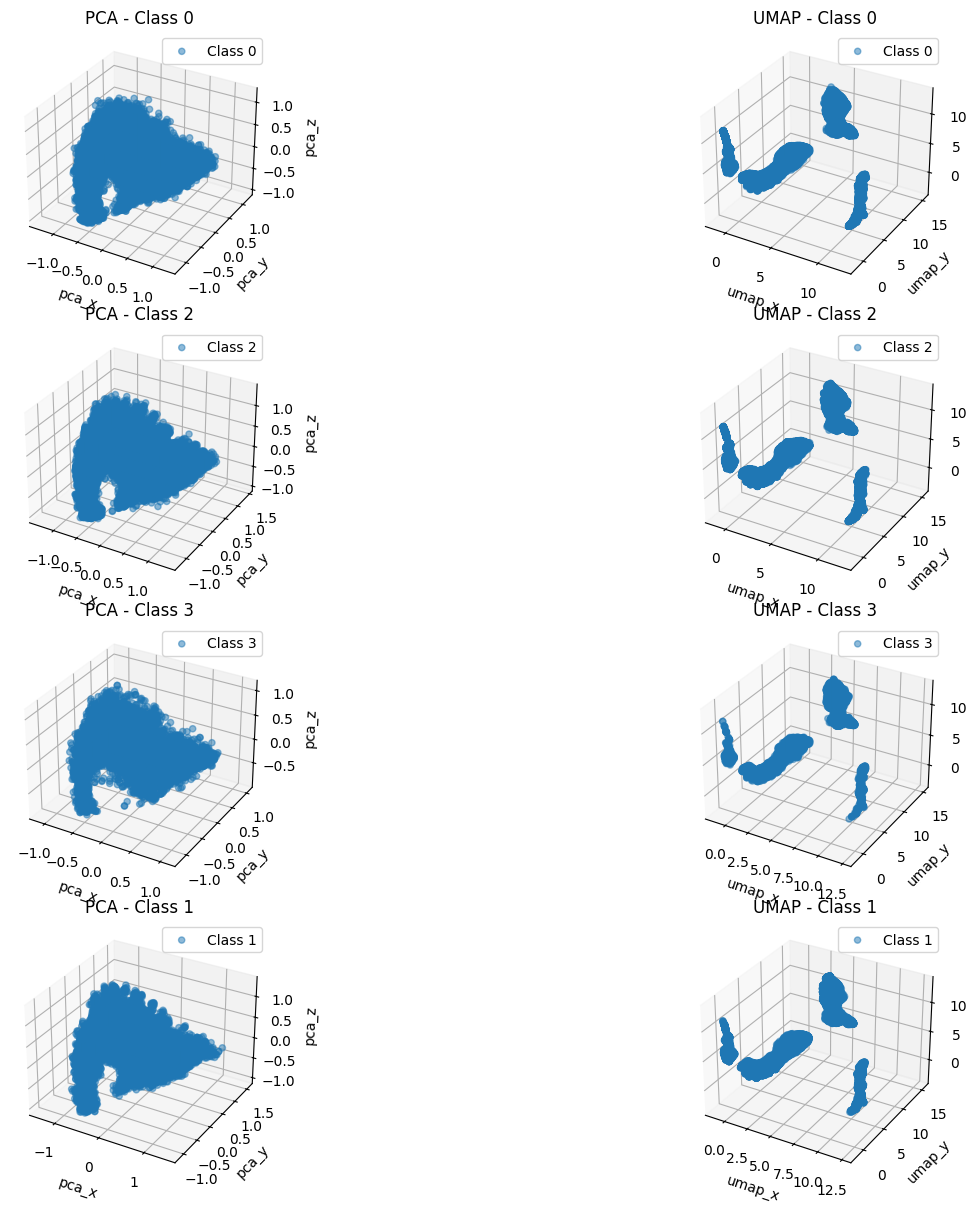

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define figure size
FS = (18, 12)

# Get unique classes
unique_classes = df['class'].unique()

# Number of rows for subplots (one row for each class)
n_rows = len(unique_classes)

# Create the figure
fig = plt.figure(figsize=FS)

# Loop through each class and create a subplot for PCA and UMAP separately
for i, cls in enumerate(unique_classes):
    # PCA 3D plot for this class
    ax_pca = fig.add_subplot(n_rows, 2, 2*i+1, projection='3d')
    class_data_pca = df[df['class'] == cls]
    ax_pca.scatter(class_data_pca['pca_x'], class_data_pca['pca_y'], class_data_pca['pca_z'], 
                   c=class_data_pca['class'], cmap='tab10', alpha=0.5, label=f'Class {cls}')
    ax_pca.set_title(f'PCA - Class {cls}')
    ax_pca.set_xlabel('pca_x')
    ax_pca.set_ylabel('pca_y')
    ax_pca.set_zlabel('pca_z')
    ax_pca.legend()

    # UMAP 3D plot for this class
    ax_umap = fig.add_subplot(n_rows, 2, 2*i+2, projection='3d')
    class_data_umap = df[df['class'] == cls]
    ax_umap.scatter(class_data_umap['umap_x'], class_data_umap['umap_y'], class_data_umap['umap_z'], 
                    c=class_data_umap['class'], cmap='tab10', alpha=0.5, label=f'Class {cls}')
    ax_umap.set_title(f'UMAP - Class {cls}')
    ax_umap.set_xlabel('umap_x')
    ax_umap.set_ylabel('umap_y')
    ax_umap.set_zlabel('umap_z')
    ax_umap.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [22]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_classif

# Assuming 'arr' is your feature array and 'classes' is your target array
# Convert to DataFrame for easier manipulation
df_features = pd.DataFrame(arr)
df_features['class'] = classes

# Separate features and target
X = df_features.drop(columns=['class'])  # Features
y = df_features['class']  # Target (classes)

# Perform ANOVA to get F-statistic and p-values
F_values, p_values = f_classif(X, y)

# Create a DataFrame to hold feature importance scores
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'F_value': F_values,
    'p_value': p_values
})

# Sort features by F_value in descending order
feature_importance = feature_importance.sort_values(by='F_value', ascending=False)

# Extract the two most differentiating features
top_2_features = feature_importance['Feature'].head(2).values

# Output the most differentiating features
print("The two most differentiating features are:", top_2_features)

# Optional: Filter the original data to include only the top 2 features
X_top2 = X[top_2_features]


The two most differentiating features are: [101 63]


/home/adam/miniconda3/envs/cells/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  7  12  14  17  18  23  28  29  30  33  36  37  39  40  42  45  50  51
  55  56  59  61  67  68  70  74  80  83  89  90  92  93  97 100 104 108
 111 114 115 123] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/adam/miniconda3/envs/cells/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


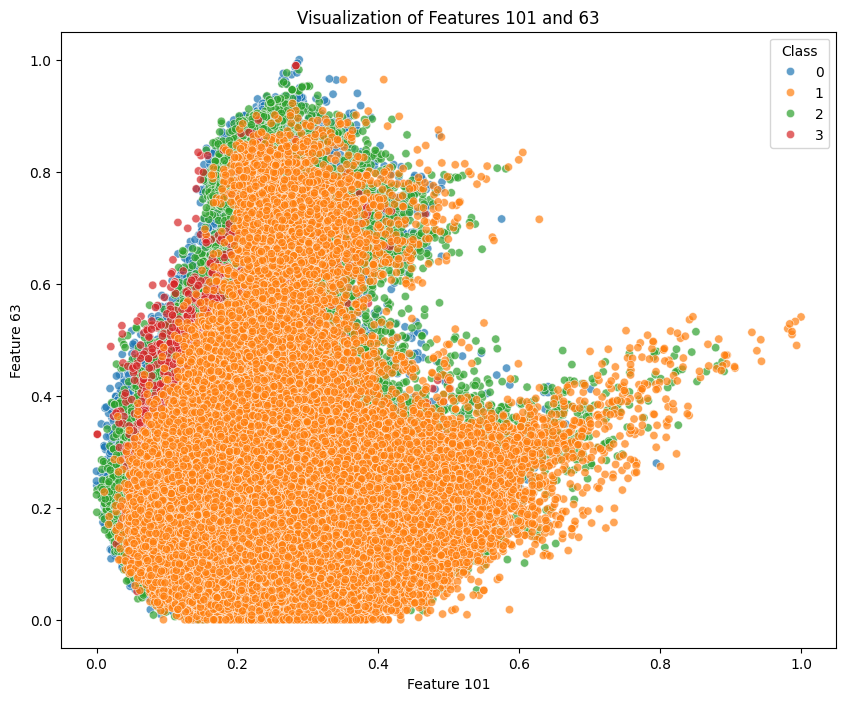

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'arr' is your feature array and 'classes' is your target array

# Extract the two most differentiating features
feature_1 = arr[:, 101]
feature_2 = arr[:, 63]

# Create a DataFrame for visualization
df_viz = pd.DataFrame({
    'feature_101': feature_1,
    'feature_63': feature_2,
    'class': classes
})

# Plot the scatter plot using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='feature_101', y='feature_63', hue='class', data=df_viz, palette='tab10', alpha=0.7)
plt.title('Visualization of Features 101 and 63')
plt.xlabel('Feature 101')
plt.ylabel('Feature 63')
plt.legend(title='Class', loc='upper right')

# Show the plot
plt.show()


In [25]:
import numpy as np
import pandas as pd
from scipy.stats import kruskal

# Assuming 'arr' is your feature array and 'classes' is your target array
# Convert to DataFrame for easier manipulation
df_features = pd.DataFrame(arr)
df_features['class'] = classes

# Separate features and target
X = df_features.drop(columns=['class'])  # Features
y = df_features['class']  # Target (classes)

# Initialize a list to hold the results
kruskal_results = []

# Perform Kruskal-Wallis test for each feature
for column in X.columns:
    stat, p_value = kruskal(*[X[column][y == cls] for cls in np.unique(y)])
    kruskal_results.append((column, stat, p_value))

# Convert results to DataFrame for easier analysis
kruskal_df = pd.DataFrame(kruskal_results, columns=['Feature', 'H_stat', 'p_value'])

# Sort features by H_stat in descending order (larger H_stat indicates more differentiation)
kruskal_df = kruskal_df.sort_values(by='H_stat', ascending=False)

# Extract the two most differentiating features
top_2_features = kruskal_df['Feature'].head(2).values

# Output the most differentiating features
print("The two most differentiating features are:", top_2_features)

# Optional: Filter the original data to include only the top 2 features
X_top2 = X[top_2_features]


ValueError: All numbers are identical in kruskal